In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd "/content/gdrive/My Drive/active_learning"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/active_learning


In [2]:
import pandas as pd
import numpy as np

**Data Loading**

In [3]:
X2 = pd.read_csv("data/regrtotaldesc.csv",index_col=0)
X2.head()

,Bit_0,Bit_1,Bit_2,Bit_3,Bit_4,Bit_5,Bit_6,Bit_7,Bit_8,Bit_9,Bit_10,Bit_11,Bit_12,Bit_13,Bit_14,Bit_15,Bit_16,Bit_17,Bit_18,Bit_19,Bit_20,Bit_21,Bit_22,Bit_23,Bit_24,Bit_25,Bit_26,Bit_27,Bit_28,Bit_29,Bit_30,Bit_31,Bit_32,Bit_33,Bit_34,Bit_35,Bit_36,Bit_37,Bit_38,Bit_39,...,Bit_984,Bit_985,Bit_986,Bit_987,Bit_988,Bit_989,Bit_990,Bit_991,Bit_992,Bit_993,Bit_994,Bit_995,Bit_996,Bit_997,Bit_998,Bit_999,Bit_1000,Bit_1001,Bit_1002,Bit_1003,Bit_1004,Bit_1005,Bit_1006,Bit_1007,Bit_1008,Bit_1009,Bit_1010,Bit_1011,Bit_1012,Bit_1013,Bit_1014,Bit_1015,Bit_1016,Bit_1017,Bit_1018,Bit_1019,Bit_1020,Bit_1021,Bit_1022,Bit_1023
Smiles,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CC1(C)c2nc(C(=O)NCc3ccc(F)cc3)c(O)c(=O)n2CCN1Cc1nnn[nH]1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
O=C(O)/C(O)=C/C(=O)c1cc(-c2ccccc2)cn1Cc1ccc(F)cc1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CC(=O)N1CCN(C)CC1(C)c1nc(C(=O)NCc2ccc(F)cc2)c(O)c(=O)[nH]1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
O=C1Sc2cc3ccccc3cc2C(=O)N2CCSC12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1
CC1(C)c2nc(C(=O)NCc3ccc(F)cc3)c(O)c(=O)n2CCN1CC(=O)N1CCCC1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [4]:
X_train2=X2.iloc[:577,:]
X_test2=X2.iloc[577:,:]
print(X_train2.shape)
print(X_test2.shape)


(577, 1024)
(143, 1024)


In [5]:
y_train2=pd.read_csv("data/regrtrainset.csv",index_col=0)
y_test2=pd.read_csv("data/regrtestset.csv",index_col=0)
y_train2=y_train2.iloc[:,1]
print(y_train2.shape)
y_test2=y_test2.iloc[:,1]
print(y_test2.shape)
#y2 = pd.concat([train.iloc[:,1], test.iloc[:,1]], axis=0)

(577,)
(143,)


In [6]:
X2=X_train2
y2=y_train2

**Data Visualization**

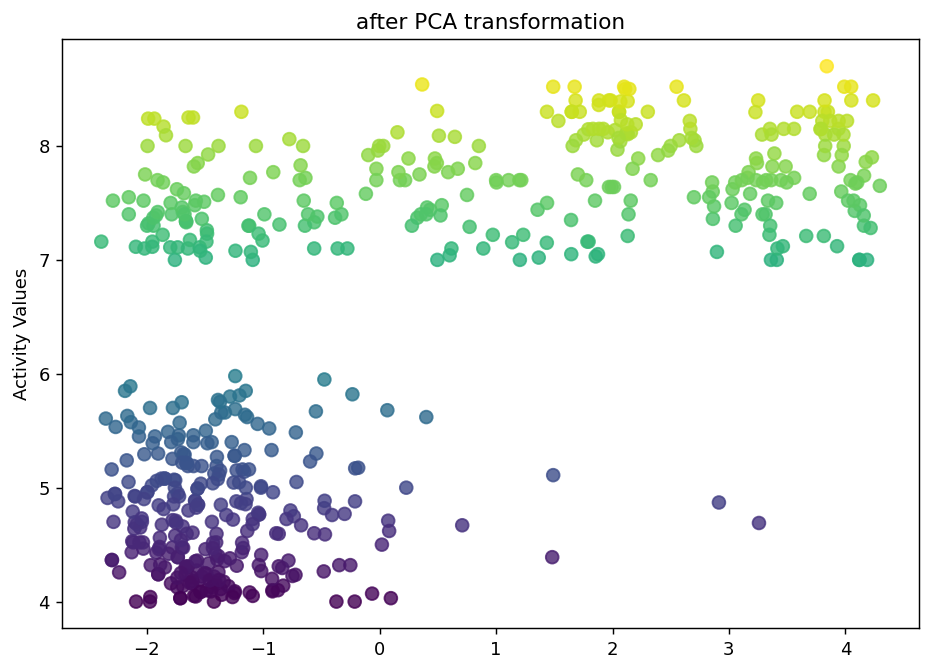

In [7]:
from sklearn.decomposition import PCA
# Define our PCA transformer and fit it onto our raw dataset.
pca = PCA(n_components=1)

transformed = pca.fit_transform(X=X2)
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# Isolate the data we'll need for plotting.
x_component = transformed[:, 0]

# Plot our dimensionality-reduced (via PCA) dataset.
plt.figure(figsize=(8.5, 6), dpi=130)
plt.scatter(x=x_component, y=y2, c=y2, cmap='viridis', s=50, alpha=8/10)
plt.title('after PCA transformation')
plt.ylabel("Activity Values")
plt.show()

In [8]:
X2=X2.values
y2=y2.values
X_test2=X_test2.values
y_test2=y_test2.values

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF
from modAL.models import ActiveLearner

%matplotlib inline

**Model Initialization and Query Strategy**

In [10]:
def GP_regression_std(regressor, X):
    _, std = regressor.predict(X, return_std=True)
    std = regressor.predict(X)
    query_idx = np.argmax(std)
    return query_idx, X[query_idx]

In [11]:
from sklearn.metrics import mean_squared_error
def max_mse(regressor, X,y):
  y_pred = regressor.predict(X)
  std=mean_squared_error(y,y_pred)
  query_idx = np.argmax(std)
  return query_idx, X[query_idx]

**Querying Data**

In [12]:
n_initial = 300
initial_idx = np.random.choice(range(len(X2)), size=n_initial, replace=False)
X_training, y_training = X2[initial_idx], y2[initial_idx]
from modAL.acquisition import max_EI
kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) \
         + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=3)
svm = SVR(kernel="poly", degree=2, C=100, epsilon=0.1)
rf=RandomForestRegressor(n_estimators=100)
regressor = ActiveLearner(
    estimator=GaussianProcessRegressor(kernel=kernel),
    query_strategy=GP_regression_std,
    X_training=X_training, y_training=y_training.reshape(-1, 1)
)

In [13]:
X_grid = X2
#y_pred, y_std = regressor.predict(X_grid, return_std=True)
y_pred = regressor.predict(X_grid)
#y_pred, y_std = y_pred.ravel(), y_std.ravel()

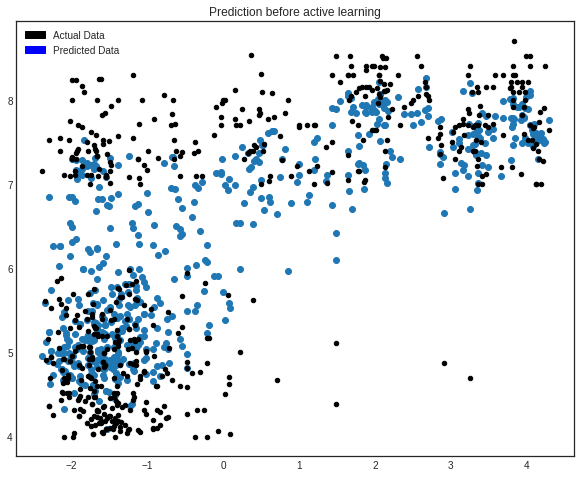

In [14]:
import matplotlib.patches as mpatches
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(10, 8))
    #plt.plot(x_component, y_pred)
    plt.scatter(x_component, y_pred)
    #plt.fill_between(x_component, y_pred - y_std, y_pred + y_std, alpha=0.2)
    plt.scatter(x_component, y2, c='k', s=20)
    plt.title('Prediction before active learning')
    black_patch = mpatches.Patch(color='black', label='Actual Data')
    blue_patch = mpatches.Patch(color='blue', label='Predicted Data')
    plt.legend(handles=[black_patch, blue_patch])
    plt.show()

In [15]:
regressor.score(X2, y2)

0.7552467950354887

In [16]:
performance_history=[]
n_queries = 30
for idx in range(n_queries):
    query_idx, query_instance = regressor.query(X2)
    regressor.teach(X2[query_idx].reshape(1, -1), y2[query_idx].reshape(1, -1))
    model_accuracy = regressor.score(X2, y2)
    print('Accuracy after query {n}: {acc:0.4f}'.format(n=idx + 1, acc=model_accuracy))
    performance_history.append(model_accuracy)

Accuracy after query 1: 0.7556
Accuracy after query 2: 0.7565
Accuracy after query 3: 0.7574
Accuracy after query 4: 0.7583
Accuracy after query 5: 0.7593
Accuracy after query 6: 0.7602
Accuracy after query 7: 0.7611
Accuracy after query 8: 0.7620
Accuracy after query 9: 0.7629
Accuracy after query 10: 0.7639
Accuracy after query 11: 0.7648
Accuracy after query 12: 0.7657
Accuracy after query 13: 0.7667
Accuracy after query 14: 0.7676
Accuracy after query 15: 0.7686
Accuracy after query 16: 0.7695
Accuracy after query 17: 0.7705
Accuracy after query 18: 0.7714
Accuracy after query 19: 0.7724
Accuracy after query 20: 0.7734
Accuracy after query 21: 0.7744
Accuracy after query 22: 0.7754
Accuracy after query 23: 0.7764
Accuracy after query 24: 0.7774
Accuracy after query 25: 0.7785
Accuracy after query 26: 0.7795
Accuracy after query 27: 0.7805
Accuracy after query 28: 0.7816
Accuracy after query 29: 0.7827
Accuracy after query 30: 0.7838


In [17]:
X_grid = X2
y_pred, y_std = regressor.predict(X_grid, return_std=True)
y_pred, y_std = y_pred.ravel(), y_std.ravel()

**Plotting Results**

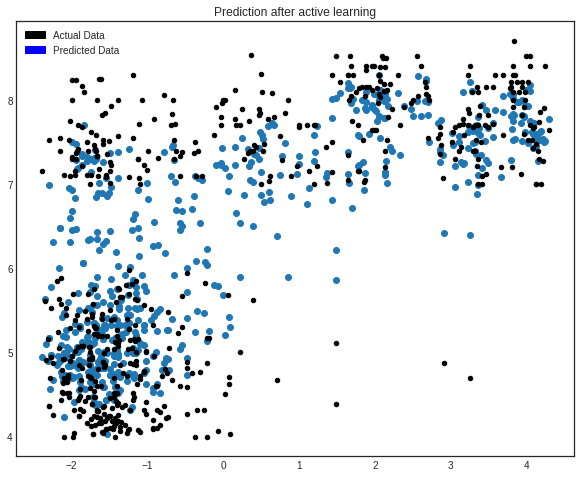

In [18]:
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(10, 8))
    #plt.plot(x_component, y_pred)
    plt.scatter(x_component, y_pred)
    #plt.fill_between(x_component, y_pred - y_std, y_pred + y_std, alpha=0.2)
    plt.scatter(x_component, y2, c='k', s=20)
    plt.title('Prediction after active learning')
    black_patch = mpatches.Patch(color='black', label='Actual Data')
    blue_patch = mpatches.Patch(color='blue', label='Predicted Data')
    plt.legend(handles=[black_patch, blue_patch])
    plt.show()

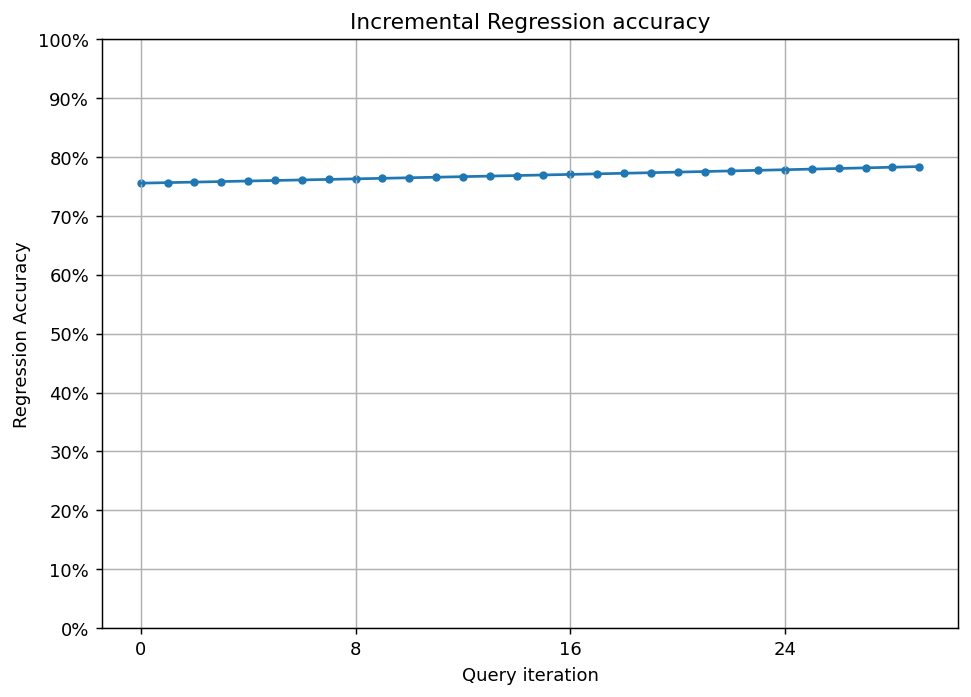

In [19]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history)
ax.scatter(range(len(performance_history)), performance_history, s=13)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental Regression accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Regression Accuracy')

plt.show()

In [20]:
from sklearn.metrics import mean_squared_error
y_pred = regressor.predict(X_test2)
y_true=y_test2
print("MSE")
print(mean_squared_error(y_true, y_pred))
from sklearn.metrics import r2_score
print("R2 Score")
print(r2_score(y_true, y_pred))

MSE
0.9418897306292198
R2 Score
0.585835882996377
